### Q2.0 k-Nearest Neighbors [30 marks]

Use **k-NN (from sklearn)** to predict gender based on student features.  
First, implement the following helper class for **feature transformations**.

---

#### Class: `PerFeatureTransformer`

```python
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        ...

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.

        Parameters:
        df : The dataframe containing features to be transformed.
        params : A dictionary mapping feature name to transformation type,
                 e.g., {"GPA": "standard", "major": "ordinal", "program": "onehot"}.
        """
        ...

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """
        Applies the fitted transformers to the corresponding features 
        and returns a NumPy array.
        """
        ...

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """
        Fits and transforms all features in one step using the 
        given transformation parameters.
        """
        ...


```python
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initializes the predictor with the full student dataset. 
        Use the username for plots."""
        ...

    def train_val_test_split(
        self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        ...

    def get_feature_matrix_and_labels(
        self, df: pd.DataFrame, features: list[str]
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Extract selected features and gender labels from the DataFrame.
        Applies encoding to categorical variables and normalizes numeric features.
        Do not fit encoders or scalers on test data. Only transform using previously fitted ones.
        """
        ...

    def get_knn_accuracy_vs_k(
        self, k_values: list[int], distance: str = "euclidean"
    ) -> list[float]:
        """Calculates accuracy scores for various k values on the validation set."""
        ...

    def plot_knn_accuracy_vs_k(
        self, k_values: list[int], distance: str = "euclidean"
    ) -> None:
        """Plots accuracy scores against k values on the validation set."""
        ...

    def get_knn_f1_heatmap(
        self, k_values: list[int], distances: list[str]
    ) -> pd.DataFrame:
        """Returns a dataframe with the F1-score for each combination on the validation set."""
        ...

    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame) -> None:
        ...

    def get_knn_f1_single_feature_table(
        self, k_values: list[int], features: list[str], distance: str = "euclidean"
    ) -> pd.DataFrame:
        """Creates a table of F1 scores on the test set using only a single feature for prediction."""
        ...


Train/val/test split the dataset and apply the data transforms. [4]

What value of k (odd values from 1 to 21) gave the highest accuracy on the validation set with Euclidean distance metric? Justify with a plot. [2]

Repeat the above for distance metrics like Manhattan and Cosine Similarity. [4]

Report the validation F-1 score vs k for all the three distance metrics. [4]

Plot a heatmap: k × distance function vs F-1 score. [4]

Which distance metric performs better? Why might that be? [2]

Instead of using all student features, an alternative is to use a single feature for prediction. Create an F-1 score table where rows are various values of k, columns are the single features used. Report values for test set for all the distance metrics. [6]

Which single feature performed the best? How does it compare with the result using all the features? Why?

In [17]:
USERNAME = "akshith.reddy"
import matplotlib.pyplot as plt

def add_username_watermark():
    plt.text(
        0.95, 0.95, USERNAME,  # use global variable
        ha='right', va='top',
        transform=plt.gca().transAxes,
        fontsize=10,
        color='gray',
        alpha=0.7
    )


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {} 
        self.params = {}       

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        self.params = params
        for feat, t_type in params.items():
            col = df[[feat]]
            if t_type == "standard":
                scaler = StandardScaler().fit(col)
                self.transformers[feat] = scaler
            elif t_type == "onehot":
                enc = OneHotEncoder(sparse=False, handle_unknown="ignore").fit(col)
                self.transformers[feat] = enc
            elif t_type == "ordinal":
                if feat == "Major":
                    enc = OrdinalEncoder(categories=[["B.Tech", "MS", "PhD"]]).fit(col)
                else:
                    enc = OrdinalEncoder().fit(col)
                self.transformers[feat] = enc


    def transform(self, df: pd.DataFrame) -> np.ndarray:
        transformed = []
        for feat, t_type in self.params.items():
            col = df[[feat]]
            transformed.append(self.transformers[feat].transform(col))
        return np.hstack(transformed)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)


In [19]:
filename = "student_dataset.csv"
df = pd.read_csv(filename)

print("Original Data:\n", df.head(), "\n")


params = {
        "GPA": "standard", 
        "Gender": "onehot",      
        "Major": "ordinal",      
        "Program": "onehot"      
}

# Major is ordinal as taken as phd>ms>btech
pft = PerFeatureTransformer()
X = pft.fit_transform(df, params)

print("Transformed Matrix:\n", X)
print("Matrix Shape:", X.shape)



Original Data:
    Gender   Major Program       GPA
0    Male      MS     CHD  6.868493
1    Male  B.Tech     CND  5.999212
2    Male     PhD     ECE  7.957554
3   Other  B.Tech     ECE  7.575683
4  Female  B.Tech     CSE  6.703073 

Transformed Matrix:
 [[-0.43607042  0.          1.         ...  0.          0.
   0.        ]
 [-1.27424211  0.          1.         ...  1.          0.
   0.        ]
 [ 0.61401592  0.          1.         ...  0.          0.
   1.        ]
 ...
 [ 1.80156367  1.          0.         ...  0.          1.
   0.        ]
 [-0.23425339  0.          1.         ...  0.          0.
   1.        ]
 [ 0.85697164  1.          0.         ...  0.          1.
   0.        ]]
Matrix Shape: (10000, 9)


C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        self.df = student_df
        self.username = username
        self.transformer = None
        self.X_train, self.X_val, self.X_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None

    def train_val_test_split(self, test_size=0.2, val_size=0.2, seed=42):
        train_df, test_df = train_test_split(self.df, test_size=test_size, random_state=seed, stratify=self.df['Gender'])
        train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=seed, stratify=train_df['Gender'])
        return train_df, val_df, test_df

    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: list[str], fit=False, params=None):
        X = df[features + ["Gender"]].copy()
        y = X["Gender"].to_numpy()
        X = X.drop(columns=["Gender"])

        if fit: 
            self.transformer = PerFeatureTransformer()
            X_trans = self.transformer.fit_transform(X, params)
        else:
            X_trans = self.transformer.transform(X)
        return X_trans, y

    def get_knn_accuracy_vs_k(self, k_values, distance="euclidean"):
        accs = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(self.X_train, self.y_train)
            preds = knn.predict(self.X_val)
            accs.append(accuracy_score(self.y_val, preds))
        return accs

    def plot_knn_accuracy_vs_k(self, k_values, distance="euclidean"):
        accs = self.get_knn_accuracy_vs_k(k_values, distance)
        plt.plot(k_values, accs, marker="o")
        add_username_watermark()
        plt.xlabel("k")
        plt.ylabel("Validation Accuracy")
        plt.title(f"KNN Accuracy vs k ({distance}) - {self.username}")
        plt.show()

    def get_knn_f1_heatmap(self, k_values, distances):
        results = {}
        for dist in distances:
            row = []
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
                knn.fit(self.X_train, self.y_train)
                preds = knn.predict(self.X_val)
                row.append(f1_score(self.y_val, preds, average="weighted"))
            results[dist] = row
        return pd.DataFrame(results, index=k_values)

    def plot_knn_f1_heatmap(self, f1_scores_df):
        plt.figure(figsize=(8,6))
        add_username_watermark()
        sns.heatmap(f1_scores_df.T, annot=True, fmt=".2f", cmap="viridis")
        plt.xlabel("k")
        plt.ylabel("Distance Metric")
        plt.title("F1 Score Heatmap (Validation)")
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values, features, distance="euclidean"):
        results = {}
        for feat in features:
            col_scores = []
            for k in k_values:
                X_train = self.X_train[:, [features.index(feat)]].reshape(-1,1)
                X_test = self.X_test[:, [features.index(feat)]].reshape(-1,1)
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train, self.y_train)
                preds = knn.predict(X_test)
                col_scores.append(f1_score(self.y_test, preds, average="weighted"))
            results[feat] = col_scores
        return pd.DataFrame(results, index=k_values)


Original Data:
    Gender   Major Program       GPA
0    Male      MS     CHD  6.868493
1    Male  B.Tech     CND  5.999212
2    Male     PhD     ECE  7.957554
3   Other  B.Tech     ECE  7.575683
4  Female  B.Tech     CSE  6.703073 

Train size=6400, Val size=1600, Test size=2000


C:\Users\mavur_crvzl5q\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


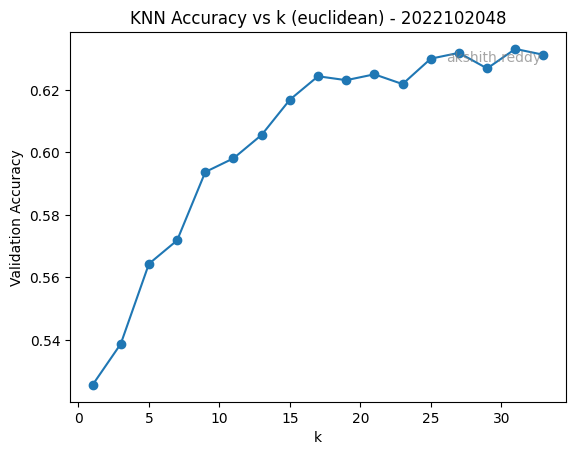

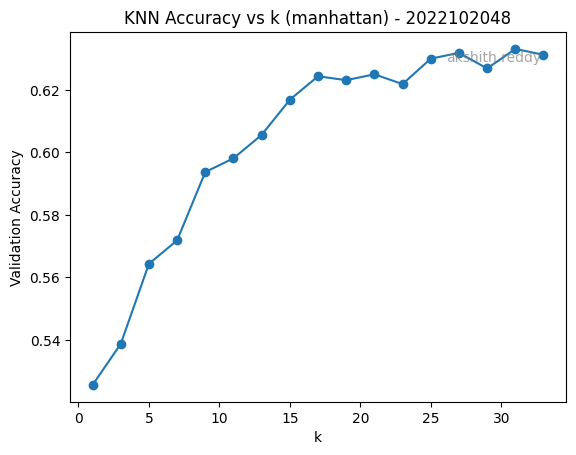

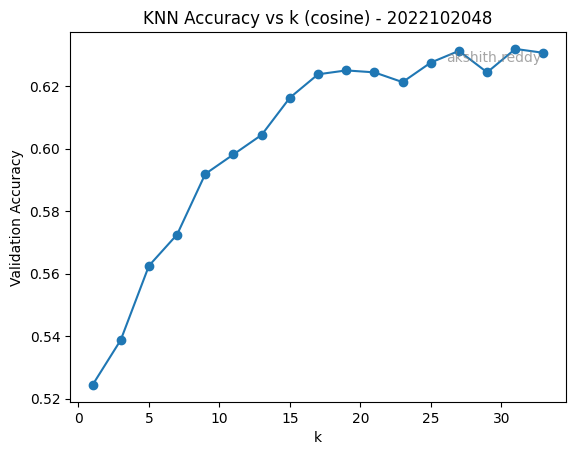

    euclidean  manhattan    cosine
1    0.527419   0.527419  0.526360
3    0.523620   0.523620  0.523903
5    0.529679   0.529679  0.527900
7    0.529612   0.529612  0.530055
9    0.541796   0.541796  0.540493
11   0.531745   0.531745  0.531745
13   0.535503   0.535503  0.534053
15   0.539435   0.539435  0.539036
17   0.540392   0.540392  0.540000
19   0.534393   0.534393  0.536933
21   0.529873   0.529873  0.526214
23   0.523237   0.523237  0.522035
25   0.523539   0.523539  0.521242
27   0.523689   0.523689  0.521515
29   0.515247   0.515247  0.511073
31   0.516531   0.516531  0.514891
33   0.512422   0.512422  0.511101


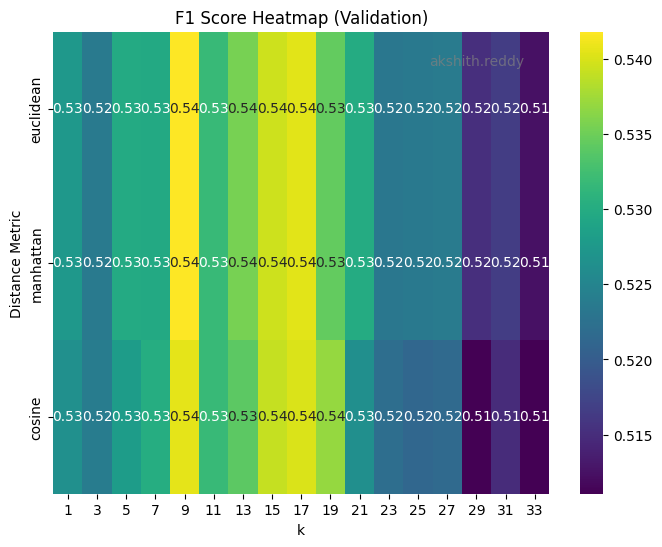


Single Feature F1 Table (Euclidean)...
         GPA     Major   Program
1   0.554571  0.544843  0.163325
3   0.557717  0.544843  0.279874
5   0.546165  0.541684  0.279874
7   0.539748  0.510224  0.279874
9   0.542017  0.408099  0.279874
11  0.546893  0.408099  0.279874
13  0.536605  0.408099  0.279874
15  0.535228  0.408099  0.279874
17  0.529181  0.408099  0.279874
19  0.535895  0.510224  0.279874
21  0.528396  0.510224  0.279874
23  0.529977  0.510224  0.279874
25  0.521227  0.510224  0.279874
27  0.521540  0.510224  0.279874
29  0.528502  0.510224  0.510224
31  0.523587  0.510224  0.510224
33  0.524775  0.510224  0.510224

Single Feature F1 Table (Cosine)...
         GPA     Major   Program
1   0.488023  0.163325  0.163325
3   0.488023  0.163325  0.279874
5   0.510224  0.163325  0.279874
7   0.510224  0.510224  0.510224
9   0.510224  0.510224  0.510224
11  0.510224  0.408099  0.279874
13  0.510224  0.544843  0.510224
15  0.510224  0.510224  0.510224
17  0.510224  0.510224  0.510224

In [21]:
def main():
    filename = "student_dataset.csv"
    df = pd.read_csv(filename)
    print("Original Data:\n", df.head(), "\n")


    params = {
        "GPA": "standard", 
        "Major": "ordinal",     
        "Program": "onehot"
    }
    features = list(params.keys())

    predictor = KNNGenderPredictor(df, username="2022102048")

    train_df, val_df, test_df = predictor.train_val_test_split()
    print(f"Train size={len(train_df)}, Val size={len(val_df)}, Test size={len(test_df)}")

    predictor.X_train, predictor.y_train = predictor.get_feature_matrix_and_labels(train_df, features, fit=True, params=params)
    predictor.X_val, predictor.y_val = predictor.get_feature_matrix_and_labels(val_df, features)
    predictor.X_test, predictor.y_test = predictor.get_feature_matrix_and_labels(test_df, features)

    k_values = list(range(1,35,2))
    accs_euclidean = predictor.get_knn_accuracy_vs_k(k_values, distance="euclidean")
    predictor.plot_knn_accuracy_vs_k(k_values, distance="euclidean")


    accs_manhattan = predictor.get_knn_accuracy_vs_k(k_values, distance="manhattan")
    predictor.plot_knn_accuracy_vs_k(k_values, distance="manhattan")

    accs_cosine = predictor.get_knn_accuracy_vs_k(k_values, distance="cosine")
    predictor.plot_knn_accuracy_vs_k(k_values, distance="cosine")

    f1_df = predictor.get_knn_f1_heatmap(k_values, ["euclidean", "manhattan", "cosine"])
    print(f1_df)
    predictor.plot_knn_f1_heatmap(f1_df)

    print("\nSingle Feature F1 Table (Euclidean)...")
    f1_single_feat = predictor.get_knn_f1_single_feature_table(k_values, features, distance="euclidean")
    print(f1_single_feat)

    print("\nSingle Feature F1 Table (Cosine)...")
    f1_single_feat_cosine = predictor.get_knn_f1_single_feature_table(k_values, features, distance="cosine")
    print(f1_single_feat_cosine)


if __name__ == "__main__":
    main()
